In [15]:
import torch
from torch import Tensor
from torch.utils import data
from torch import nn
import pytorch_lightning as pl
from torch import functional as F
# Defining Sinusoidal Sequence


class SinusoidalData(data.Dataset):
    def __init__(self, start, end, count, smpl_len, pred_offset):
        super().__init__()
        self.smpl_len = smpl_len
        self.pred_offset = pred_offset
        self.sequence = torch.sin(torch.arange(start, end, step=(end - start) / count))
        
    def __len__(self):
        return self.sequence.shape[0] - (self.smpl_len + self.pred_offset)
    
    def __getitem__(self, index):
        X, y = self.sequence[index:index + self.smpl_len], self.sequence[index + self.smpl_len + self.pred_offset - 1]
        return (X, y.unsqueeze(0))
        
        
    
class FFN(pl.LightningModule):
    def __init__(self, n_steps, lr=1e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = nn.Sequential(nn.Linear(n_steps, n_steps * 2), nn.ReLU(),
                                   nn.Linear(n_steps * 2, n_steps * 2), nn.ReLU(),
                                   nn.Linear(n_steps * 2, 1))
        self.lr = lr
        self.loss = nn.MSELoss()
        
    def forward(self, X):
        return self.model(X)
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.model(X)
        assert(isinstance(y_hat, torch.Tensor))
        assert(isinstance(y, torch.Tensor))
        assert(isinstance(self.loss, nn.MSELoss))
        loss = self.loss(y_hat, y)
        if batch_idx % 5 == 0:
            self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.lr)
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.model(X).reshape(y.shape)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss)
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.model(X).reshape(y.shape)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("test_loss", loss)

In [16]:
import math

dataset = SinusoidalData(0, 2 * math.pi, 2000, 10, 1)


In [27]:
import pytorch_lightning as pl
import math
from pytorch_lightning import callbacks
import os

dataset = SinusoidalData(0, 2 * math.pi, 2000, 10, 1)
train_dataset, val_dataset = data.random_split(dataset, [0.9, 0.1])
train_loader = data.DataLoader(train_dataset, batch_size=10, num_workers=os.cpu_count())
val_loader = data.DataLoader(val_dataset, batch_size=10, num_workers=os.cpu_count())
model = FFN(10)


ckpt_callback = callbacks.ModelCheckpoint(dirpath='./model', 
                                          filename='ffn-autoregress-test-{epoch}-{val_loss:.2f}',
                                          monitor='val_loss',
                                          mode='min',
                                          save_top_k=2)

early_stop = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)

trainer = pl.Trainer(accelerator="gpu", callbacks=[ckpt_callback, early_stop], max_epochs=100)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fritzprix/miniconda3/envs/directml/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/fritzprix/my_work/ml_note/labs/sin_sequence_model/model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 661   
1 | loss  | MSELoss    | 0     
-------------------------------------
661       Trainable params
0         Non-trainable params
661       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/fritzprix/miniconda3/envs/directml/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [47]:
from tqdm import tqdm
from matplotlib import pyplot as plt

def predict_k_step(model, data_loader, k_step=1, device=torch.device("cpu")):
    pred = []
    label = []
    for X, y in tqdm(iter(data_loader)):
        assert(isinstance(X, torch.Tensor))
        assert(isinstance(y, torch.Tensor))
        X = X.to(device)
        y = y.to(device)
        model = model.to(device) 
        for i in range(k_step):
            y_hat = model(X)
            X = torch.cat([X, y_hat], dim=1)[:,1:]
        label.append(y)
        pred.append(y_hat)
    pred = torch.cat(pred, dim=1).squeeze(0)
    label = torch.cat(label, dim=1).squeeze(0)
    loss = torch.nn.functional.mse_loss(pred,label)
    return (pred, label, loss)

def draw_timeseries_compare(ts: list[torch.Tensor], labels: list[str], losses: list[torch.Tensor]):
    fig = plt.figure()
    for batch, loss in zip(zip(ts, labels), losses):
        ts, label = batch
        plt.plot(ts.detach().numpy(), label=f"{label} @ {loss}")

    plt.legend()
    plt.show()
        


In [45]:
import pytorch_lightning as pl
import math
from torch.utils import data

n_steps = 10

data_loader = data.DataLoader(dataset)


model = FFN.load_from_checkpoint('./model/ffn-autoregress-test-epoch=99-val_loss=0.00.ckpt')


100%|██████████| 1989/1989 [00:00<00:00, 29778.05it/s]


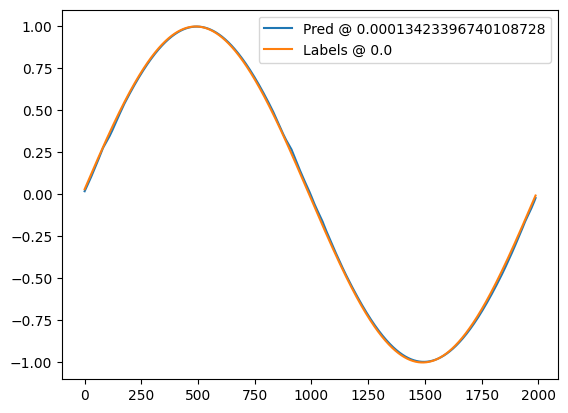

In [48]:
from tqdm import tqdm
pred = []
labels = []
for X, y in tqdm(iter(data_loader)):
    pred.append(model(X))
    labels.append(y)
    
pred = torch.cat(pred, dim=1).squeeze(0)
labels = torch.cat(labels, dim=1).squeeze(0)
loss = torch.nn.functional.mse_loss(pred, labels)

draw_timeseries_compare([pred, labels], ["Pred", "Labels"], [loss, torch.scalar_tensor(0)])



- Step 1 prediction의 결과 거의 0에 수렴하는 mse loss값을 보임
- prediction step을 증가 시킬 때 오차가 얼마나 증가하는지 테스트

100%|██████████| 1989/1989 [00:10<00:00, 198.83it/s]


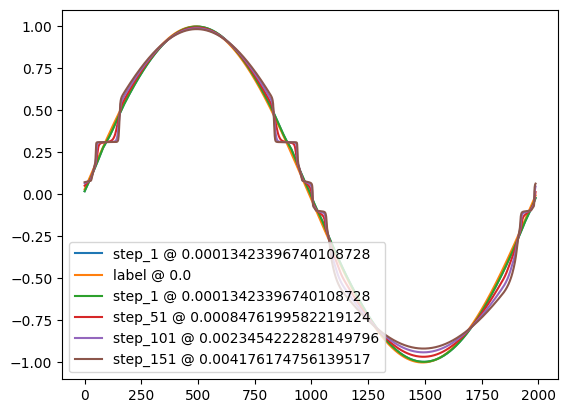

In [49]:


series = []
labels = []
losses = []

pred_k, label, loss = predict_k_step(model, data_loader, 1)
series.append(pred_k)
labels.append("step_1")
series.append(label)
labels.append("label")
losses.append(loss)
losses.append(torch.scalar_tensor(0))

for i in range(1, 200, 50):
    pred, _, loss = predict_k_step(model, data_loader, i)
    labels.append(f"step_{i}")
    series.append(pred)
    losses.append(loss)

    

draw_timeseries_compare(series, labels, losses)




- step 151에서 loss는 0.004로 step 1 대비 약 40배 증가
- 이처럼 step size 증가할 수록 error가 커짐

In [6]:
import pytorch_lightning as pl
import torch
from torch import nn

class SelectItem(nn.Module):
    def __init__(self, idx):
        super().__init__()
        self.idx = idx
        
    def forward(self, inputs) -> torch.Tensor:
        return inputs[self.idx]
        


class GRUAutoregress(pl.LightningModule):
    def __init__(self, n_steps, lr=1e-4):
        super().__init__()
        self.lr = lr
        self.model = nn.Sequential(
            nn.GRU(input_size=1, hidden_size=10, batch_first=True),
            SelectItem(0),
            nn.Flatten(),
            nn.Linear(100, 1)
        )
        self.loss = nn.MSELoss()
        self.save_hyperparameters()
        
    def forward(self, X):
        assert(isinstance(X, torch.Tensor))
        X = X.unsqueeze(dim=2)
        return self.model(X)
    
    def training_step(self, batch, batch_idx) -> torch.Tensor:
        X, y = batch
        assert(isinstance(X, torch.Tensor))
        assert(isinstance(y, torch.Tensor))
        y_hat = self(X)
        loss = self.loss(y_hat, y)
        return loss
        
    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def validation_step(self, batch, batch_idx):
        X,y = batch
        assert(isinstance(X, torch.Tensor))
        assert(isinstance(y, torch.Tensor))
        y_hat = self(X)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss)
        return {"val_loss": loss}
    
    def test_step(self, batch, batch_idx):
        X,y = batch
        assert(isinstance(X, torch.Tensor))
        assert(isinstance(y, torch.Tensor))
        y_hat = self(X)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("test_loss", loss)
        return {"test_loss": loss}

In [7]:
from pytorch_lightning import callbacks
from torch.utils import data
import os

ckpt_callback = callbacks.ModelCheckpoint('./model/gru', 
                                          filename='gru-autoregress-{val_loss:.2f}-{epoch}.ckpt',
                                          monitor='val_loss',
                                          mode='min',
                                          save_top_k=2)

model = GRUAutoregress(10)
train_dataset, val_dataset =  data.random_split(dataset, [0.9, 0.1])

train_loader = data.DataLoader(train_dataset, batch_size=10, num_workers=os.cpu_count())
val_loader = data.DataLoader(val_dataset, batch_size=10, num_workers=os.cpu_count())

trainer = pl.Trainer(accelerator="gpu", callbacks=[ckpt_callback], max_epochs=100)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fritzprix/miniconda3/envs/directml/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/fritzprix/my_work/ml_note/labs/sin_sequence_model/model/gru exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 491   
1 | loss  | MSELoss    | 0     
-------------------------------------
491       Trainable params
0         Non-trainable params
491       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/fritzprix/miniconda3/envs/directml/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [39]:
import os
from torch.utils import data
import pytorch_lightning as pl
from tqdm import tqdm




model = GRUAutoregress.load_from_checkpoint('./model/gru/gru-autoregress-val_loss=0.00-epoch=98.ckpt-v1.ckpt')
model = model.to(torch.device("cpu"))

# result = trainer.test(model=model, dataloaders=data_loader)

def k_step_eval(model: pl.LightningModule, dataset: data.Dataset, k: int):
    pred = []
    model.eval()
    for X, y in tqdm(dataset):
        y_hat = y
        for step in range(k):
            assert(isinstance(X, torch.Tensor))
            assert(isinstance(y, torch.Tensor))
            y_hat = model(X.unsqueeze(0)).squeeze(0)
            X = torch.cat([X, y_hat])[1:]
        pred.append(y_hat.item())
    return pred
            
        

preds = [k_step_eval(model=model, dataset=dataset, k=k) for k in range(0, 200, 50)]

    

1990it [00:00, 398446.87it/s]           
1990it [00:20, 99.10it/s]                           
1990it [00:43, 45.95it/s]                          
1990it [01:06, 29.99it/s]                          


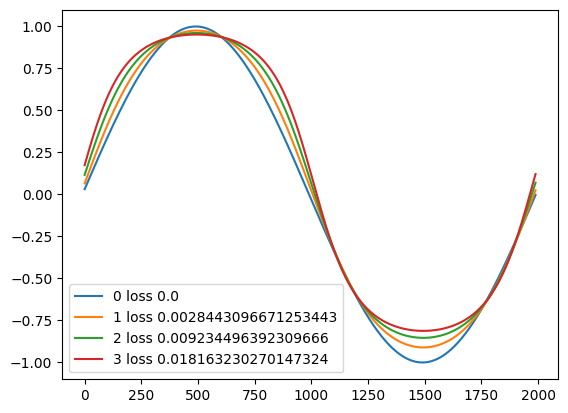

In [55]:
from matplotlib import pyplot as plt
from torch.nn import functional as F

def draw_comparison_chart(predicts:list, ref_idx: int = 0):
    predict_tensors = [torch.Tensor(pred) for pred in preds]
    fig = plt.figure()
    for idx, pred in enumerate(predict_tensors):
        loss = F.mse_loss(pred, predict_tensors[0])
        plt.plot(pred, label=f"{idx} loss {loss}")
    plt.legend()
    plt.show()
    
draw_comparison_chart(preds, 0)